### Imports

In [13]:
import pandas as pd
import json
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re
import shap
import pickle

sys.path.append("../")
pl.Config.set_tbl_rows(50)

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa

# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

### constants

In [8]:
FILES_DIR = "../data"

### select data

In [9]:
# os.path.join(FILES_DIR, path)

In [ ]:
path = "data_for_models"
os.makedirs(os.path.join(FILES_DIR, path), exist_ok=True)
file_name = "imputed_labeled_data.parquet"
file_path = os.path.join(FILES_DIR, path, file_name)
labeled_data = pl.read_parquet(file_path)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "numerical_cols.pickle"), "rb"
) as f:
    numerical_cols = pickle.load(f)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "discrete_cols.pickle"), "rb"
) as f:
    discrete_cols = pickle.load(f)

In [23]:
discrete_cols.pop(discrete_cols.index("target"))

'target'

In [16]:
labeled_data["target"].value_counts()

target,count
f64,u32
1.0,473
-1.0,6289
0.0,518


In [17]:
labeled_data.sample(2)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,main_disease_I21,main_disease_I20,disease_E03,disease_D64,disease_I63,disease_U07,disease_G93,disease_N20,disease_I49,disease_N40,disease_B18,disease_I70,disease_E74,disease_I69,disease_H90,disease_K29,disease_M42,disease_I25,disease_I71,disease_E06,disease_J45,disease_C18,disease_I35,disease_K26,disease_I50,disease_C50,disease_I11,disease_I83,disease_I34,disease_I48,disease_I44,disease_I67,disease_J44,disease_N18,disease_I64,disease_E66,disease_I47,disease_K25,disease_I45,disease_N28,disease_E04,disease_C61,disease_J42,disease_K80,disease_C34,disease_L40,disease_E11,disease_K86,disease_M10,disease_D50,disease_E10,bmi
datetime[ms],f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-10-03 00:00:00,1.0,"""4DBA66D6-D0D7-5119-E055-000000…",0.0,1.0,-1.0,2.0,0.0,0.0,3.8,3.6,3.1,122.0,55.0,67.0,56.0,1.1,3.2,0.5,45.0,91.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.118072
2021-04-12 00:00:00,1.0,"""8B1DEF07-FEDC-4037-9DEF-07FEDC…",0.0,1.0,1.0,2.0,1.0,0.0,4.2,4.0,3.0,88.0,36.0,52.0,58.0,1.2,3.6,0.7,57.0,74.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,28.024122


### split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    labeled_data.select(discrete_cols + numerical_cols),
    labeled_data["target"],
    test_size=0.2,
    random_state=1,
)

X_train, X_eval, y_train, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=1,
)  # 0.25 x 0.8 = 0.2

In [ ]:
# cat_cols = X_train.select(
#     pl.selectors.by_dtype(pl.String),
# ).columns

### catboost

In [26]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols,
    eval_metric="AUC",
    depth=3,
    iterations=500,
    learning_rate=0.06,
)

model.fit(
    X=X_train.to_pandas(),
    y=y_train.to_pandas(),
    early_stopping_rounds=50,
    verbose=True,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

metric = roc_auc_score(y_test, model.predict_proba(X_test.to_pandas())[:, 1])
print(metric.round(3))

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=0]=0.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

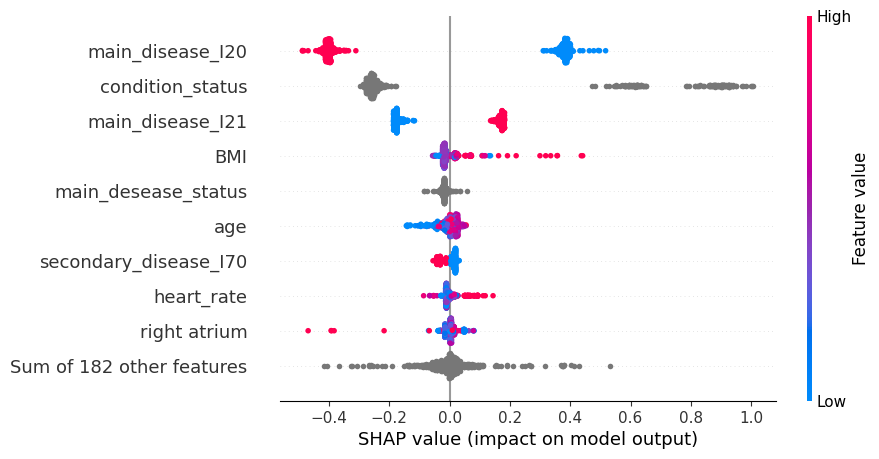

In [119]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train.to_pandas())
shap.plots.beeswarm(
    shap_values,
    plot_size=(8, 5),
)
plt.show()

### automl